We would like to look into how much the Bitcoin price itself depends on some Bitcoin market parameters like market cap (the total value of all coins mined) or on-change transaction volume (measure of the total value of outputs on the blockchain on a given day). It seems promising to find some relation from such data, as we know that the more people buy the higher the price should be and vice versa. To do that, we will try to use some regression models on the following *Datahub* [Bitcoin dataset](https://datahub.io/cryptocurrency/bitcoin).

For the sake of this notebook we took inspiration from the Regression lecture and notebooks from this course. 

Knowing how much Bitcoin's price graphs fluctuate, our intuition was that some non-linear regression could have a chance to tackle that problem. We imagined that the ever-fluctuating Bitcoin price could be possibly modeled with some polynolmial of higher degree. That's what we'll try to explore in this notebook. 

Firstly, we will install the *datapackege* to import the dataset

In [ ]:
!pip install datapackage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.0 MB/s 
     |████████████████████████████████| 68 kB 4.3 MB/s 
     |████████████████████████████████| 72 kB 353 kB/s 
     |████████████████████████████████| 41 kB 555 kB/s 
     |████████████████████████████████| 132 kB 67.8 MB/s 
     |████████████████████████████████| 126 kB 47.5 MB/s 
     |████████████████████████████████| 79 kB 8.9 MB/s 
     |████████████████████████████████| 8.8 MB 46.8 MB/s 
     |████████████████████████████████| 127 kB 55.3 MB/s 
  Created wheel for linear-tsv: filename=linear_tsv-1.1.0-py3-none-any.whl size=7400 sha256=fe6a6be4958e8f1fc1a60f34728e7496efea0c890a29a43d07bb8e4322fd4314
  Stored in directory: /root/.cache/pip/wheels/dd/0a/62/49ee84fab92057fb3e303fb1a59e75ccac6899b417f441305a
  Created wheel for unicodecsv: filename=unicodecsv-0.14.1-py3-none-any.whl size=10768 sha256=a49ffd59d1a31f43cf1058a4351181f

Then we import some packages and set *matplotlib* settings.

In [107]:
# imports 
import numpy as np
import pandas as pd  
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
import itertools
import datetime
from datapackage import Package
from sklearn.svm import SVR
from pandas.core.frame import DataFrame

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Then we load our dataset into a DataFrame object and do some preprocessing. 
It includes standardizing the data, as we can not really use as big of numbers as a for example the *txCount*, which is the total of Bitcoin transactions per day, which as we are writing this is around 290k. We were a bit concerned though, that standardizing price data might lead to some rounding errors, and thus we'll introduce some noise into our dataset. Nevertheless, we don't think the models will learn well on non-standardized data, so we standardize it.

In [108]:
# dataset loading

package = Package('https://datahub.io/cryptocurrency/bitcoin/datapackage.json')

df=[]

# read pcsv data (if exists any)
for resource in package.resources:
    if resource.descriptor['datahub']['type'] == 'derived/csv':
        df=resource.read()

# convert to pandas data frame + preprocessing
df=pd.DataFrame(df,columns=['date', 'txVolume(USD)', 'adjustedTxVolume(USD)', 'txCount', 'marketcap(USD)', 'price(USD)', 'exchangeVolume(USD)', 'generatedCoins','fees', 'activeAddresses', 'averageDifficulty', 'paymentCount', 'medianTxValue(USD)', 'medianFee','blockSize', 'blockCount'])

# get rid of all the half-empty rows, ie. until 2013-04-28, getting rid of first 1571 rows
df=df[df.date>datetime.date(2013,4,28)]

# some preprocessing
dates = df['date']
no_dates = df.drop('date', axis=1)
no_dates = no_dates.apply(pd.to_numeric,errors='coerce', axis=1)

# we want to predict the 'price(USD)' value using all other variables (for now)
y = pd.to_numeric(df['price(USD)'])
X = no_dates.drop('price(USD)', axis=1)

# standardizing 

y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std


X_mean = X.mean()
X_std = X.std()
X = (X - X_mean) / X_std




We define an error estimating function 

In [109]:
# defining an error function
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

Then we split the data into train and test sets and permutate it. For the sake of this notebook, we are not bothered by the time series relation, that's why we happily permutate the set. By trial and error, we reached a rather higher percentage of the train data. But it agrees with our intention to include as many fluctuations in the train data as possible, hoping that it will give our model a better insight. 

In [110]:
def split_into_train_and_test(X,y,train_perc=0.9):
  split_point = int(train_perc*len(y))
  perm = np.random.permutation(len(y))
  ix_train = perm[:split_point]
  ix_test = perm[split_point:]
  X = X.to_numpy()
  y = y.to_numpy()
  X_train = X[ix_train,:]
  X_test = X[ix_test,:]
  y_train = y[ix_train]
  y_test = y[ix_test]
  return X_test,X_train,y_test,y_train

In [111]:
X_test,X_train,y_test,y_train = split_into_train_and_test(X,y)

To check out our polynolmial regression idea, we try to train an Epsilon-Support Vector Regression from *scikit-learn*. The kernel of the model is chosen to be polynomial with a degree 3. It did not really fit our intuition of a high degree polynolmial, as we imagined a degree of at least 10, but for *degree=3* we got the best results. By trial and error, we also adjusted the other parameters like *gamma*, *epsilon* and *C*. 

After the model is trained and tested, we convert the data back to its original scale, as it was standerdized before. 

In [112]:
def train_predict_poly_regression(X_train,y_train, X_test,kernel='poly'):
  C=1000 
  gamma=0.01
  epsilon=0.01
  degree=3
  svrrbf = SVR(kernel=kernel, degree=degree, C=C, gamma=gamma, epsilon=epsilon)
  svrrbf.fit(X_train, y_train)
  y_hat = svrrbf.predict(X_test)
  return y_hat

def convert_back_to_scale(y_hat,y_std,y_mean,y_test):
  preds = y_hat * y_std + y_mean
  y_true = y_test * y_std + y_mean
  return preds,y_true

In [113]:
y_hat=train_predict_poly_regression(X_train,y_train,X_test)
preds, y_true = convert_back_to_scale(y_hat,y_std,y_mean,y_test)
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.987
MAE: 156.356
RMSE: 681.027
R2: 0.967


The results are not as promising as we would have hoped. The MAE suggests that on average our prediction is off by 238 USD. We can take a look at a graph of a subset of our predictions for better visualization. 

Whenever we plot our graphs, predicted price values are in blue, while the actual price values are in red. 

In [114]:
def plot_a_range(range):
  plt.plot(preds[:range],'bo')
  plt.plot(y_true[:range],'r+')

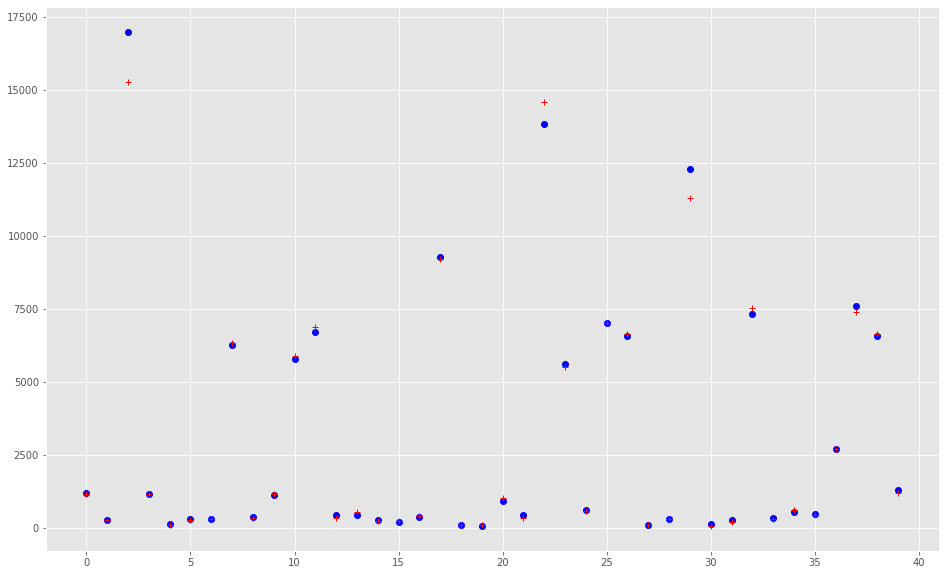

In [115]:
# plot a range
plot_range=40
plot_a_range(plot_range)


Naturally, the bigger the price, the bigger our error is. We also have some outliers. To be honest, we no longer think that a polynomial modelling is a good solution here. 

So we tried an rbf kernel, which is supposed to be an equivalent of using a polynomial kernel with an infinite degree.

CorrCoef: 1.000
MAE: 23.919
RMSE: 89.172
R2: 0.999


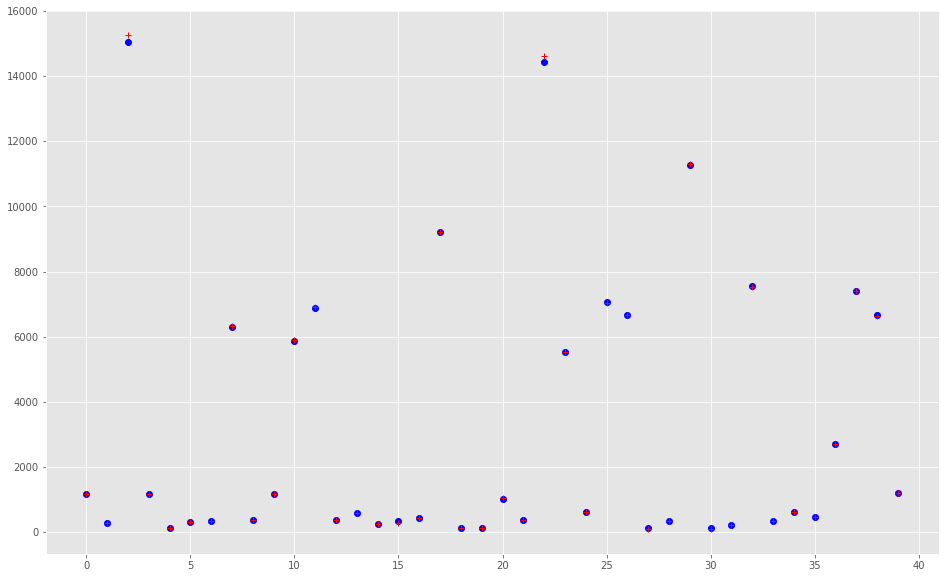

In [116]:
y_hat=train_predict_poly_regression(X_train,y_train,X_test,kernel='rbf')
preds, y_true = convert_back_to_scale(y_hat,y_std,y_mean,y_test)
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))
plot_a_range(plot_range)

We actually got much nicer results then earlier. Not only are the MAE and RMSE 5-10x smaller than before, but also the R2 is much closer to 1. 

Just out of curiosity, we also tried a good old-fashioned linear regression.

In [117]:
def train_and_test_linear_regression():
  regr = linear_model.LinearRegression()
  regr.fit(X_train, y_train)
  y_hat = regr.predict(X_test)
  return y_hat

CorrCoef: 1.000
MAE: 24.193
RMSE: 34.160
R2: 1.000


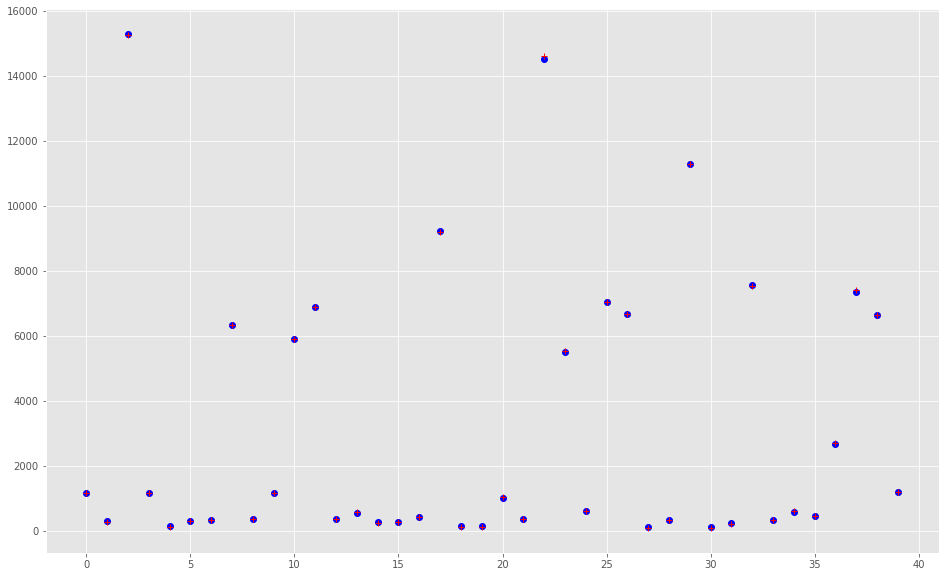

In [118]:
y_hat = train_and_test_linear_regression()
preds, y_true = convert_back_to_scale(y_hat,y_std,y_mean,y_test)
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))
plot_a_range(plot_range)

The error estimation looks even better than our non-linear rbf regression, with a lower RMSE. Maybe it is also because our data is standardized, which flattens the data. 

We started wondering if maybe our features are too correlated with price. Thus we wanted to look into some feature selection. 

In [121]:
# feature selection
from sklearn.feature_selection import SelectKBest, f_regression

# configure to select all features
X = SelectKBest(score_func=f_regression).fit_transform(X,y)


This way we got rid of 4 features. Then we ran our models again. Firstly, the non-linear regression with *rbf* kernel

In [122]:
X_test,X_train,y_test,y_train = split_into_train_and_test(pd.DataFrame(X),y)

CorrCoef: 1.000
MAE: 17.451
RMSE: 21.963
R2: 1.000


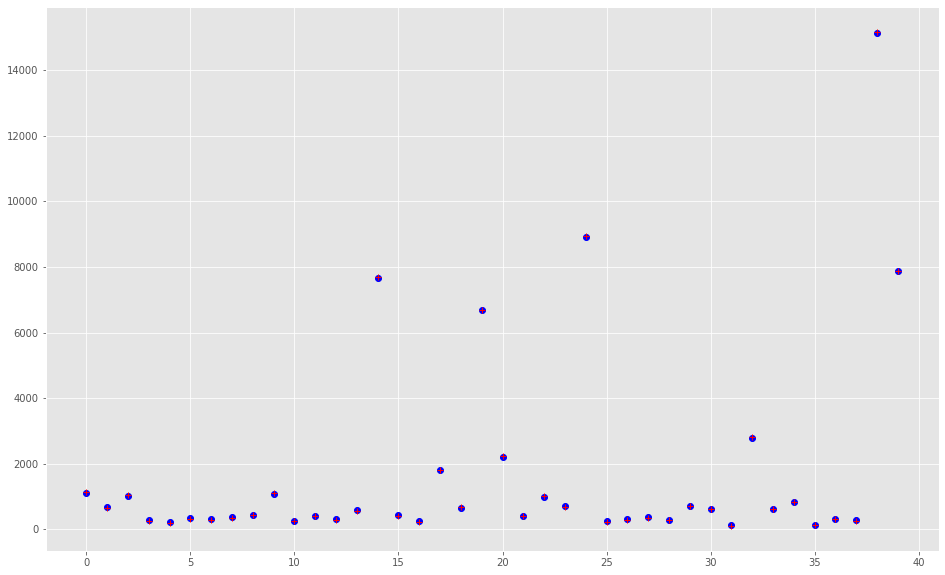

In [123]:
y_hat=train_predict_poly_regression(X_train,y_train,X_test,kernel='rbf')
preds, y_true = convert_back_to_scale(y_hat,y_std,y_mean,y_test)
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))
plot_a_range(plot_range)

And our linear regression model

CorrCoef: 1.000
MAE: 29.812
RMSE: 46.571
R2: 1.000


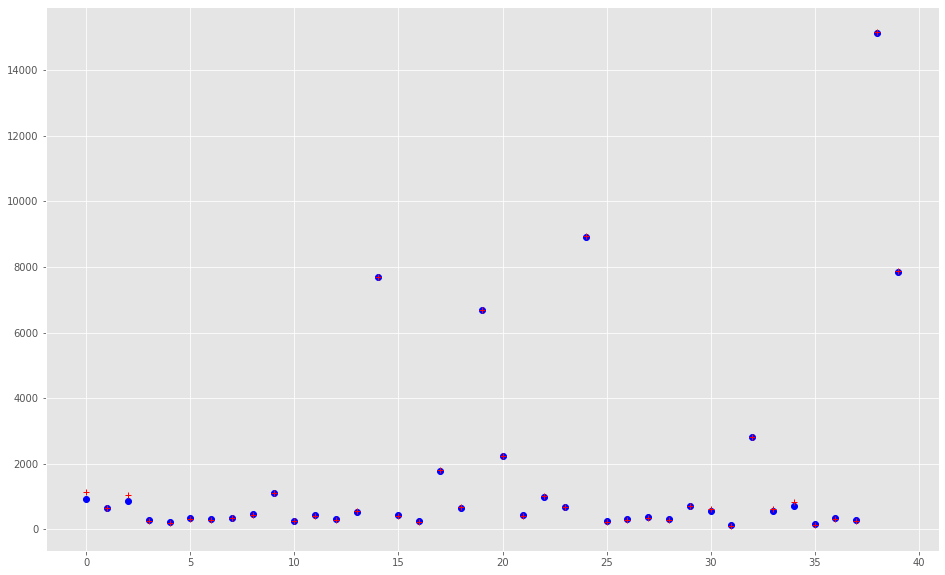

In [129]:
y_hat = train_and_test_linear_regression()
preds, y_true = convert_back_to_scale(y_hat,y_std,y_mean,y_test)
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))
plot_a_range(plot_range)

Now we have reached a more convincing state, where non-linear regression does better that the linear one ( oof :) ). However, the linear one is not that much worse. 

As a conclusion, we can say that non-linear regression with the *rbf* kernel has proven to be most promising. Our models' predictions suggest that the market data from our dataset can be used to some extent effectively to infer the price. However, we do realize that the actual Bitcoin price depends on many other factors as well.

We were quite surprised that the linear regression did so well. We are wondering if it's maybe due to the presence of outliers in our dataset, that do affect the polynomial regression. We also guess that some of the features like total transactions per day or marketcap are quite correlated with price, which makes it easier for the linear regression to work. 